In [19]:
import cv2 
from matplotlib import pyplot as plt
from pathlib import Path
from skimage import io
from skimage import img_as_ubyte
import numpy as np
from pathlib import Path
from skimage import io
from skimage import color
from skimage import measure
from skimage import morphology
from skimage import transform
import re
import tensorflow as tf    
import keras
from keras.utils import to_categorical
from keras import layers, models, callbacks
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import glob
import cv2
import json
import os


WYKRYWANIE ZNAKÓW CANNY

In [20]:
def get_canny_files():
    source_path_org = Path('../data/ocr1')
    save_path_org = Path('../data/canny')
    save_path_org.mkdir(parents=True, exist_ok=True)

    images_paths = source_path_org.glob("*.jpg")
    counter = 1
    for i in images_paths:
        img = io.imread(i)
        img = img_as_ubyte(img)
        edges = cv2.Canny(img,220,330)
    #     edges = cv2.Canny(img,60,300)
        # edges = cornerEigenValsAndVecs(img)
    #     cv2.imwrite('file{0}.png'.format(i), edges)
#         print(i)
        io.imsave(arr=edges, fname=save_path_org / 'img_{}.png'.format(counter))
        counter +=1
#         plt.gcf().set_size_inches(30, 20)

#         plt.imshow(edges,cmap = 'gray')
#         plt.title('Edge Image{0}'.format(i)), plt.xticks([]), plt.yticks([])
#     #     plt.savefig('file{0}.png'.format(i))
#         plt.show()

ROZDZIELANIE SŁÓW 

In [12]:
def detect_lines_of_text(img):    
    # obliczamy średnią jasność wierszy w obrazie
    sum_of_rows = np.sum(img, axis=1) 
    mean_row_value = np.mean(sum_of_rows)
    
    # wiersze poniżej średniej jasności zerujemy (usuwa np. ogonki liter nachodzących na kolejne wiersze)
    for i, row in enumerate(img):
        if np.sum(row) < mean_row_value:
            row = np.zeros(row.shape)
            img[i] = row
        
    # zaznaczamy obszary, które są powyżej średniej (całe wiersze)
    for i, row in enumerate(img):
        if np.mean(row) > 0.0:
            img[i:i+1, :] = 1 
            
    # łączenie lekko rozdzielonych linijek
    img = morphology.dilation(img, morphology.disk(7)) # TODO WAŻNE - zoptymalizować!
                
    return img
            

def detect_words_in_line(image_org, coords_of_line):
    # wycinamy kawałek obrazu będącego linią tekstu i obracamy go (.T)
    line_img = get_slice_of_image_with_specific_coords(image=image_org, coords=coords_of_line).T
    line_img = morphology.dilation(line_img, morphology.disk(17))
    
    # szukamy miejsc, w których jasność jest większa od 0.0 i te miejsca zaznaczamy w wycinku obrazu
    # (całe wiersze, tutaj poprzez obrócenie są to pojedyczne wyrazy)
    sum_of_rows = np.sum(line_img, axis=1) 
    mean_row_value = np.mean(sum_of_rows)
    for i, row in enumerate(line_img):
        if np.mean(row) > 0.0:
#             line_img[i:i+1, :] = (255, 0, 0)
            line_img[i:i+1, :] = 255
    line_img = line_img.T
    
    
    label_line_img = measure.label(line_img)
    regions = measure.regionprops(label_line_img)
#     print("liczba słów: ", len(regions))
    
    max_width_coord = max(regions[0].coords[:, 1])
    max_region_index = 0
    for i, region in enumerate(regions[1:]):        
        temp = max(region.coords[:, 1])
        if temp > max_width_coord:
            max_width_coord = temp
            max_region_index = i + 1
            
    last_word_coords = regions[max_region_index].coords
    last_word_coords[:,0] += coords_of_line[0][0]
    
    # zamieniamy ten wycinek obrazu w całym obrazie
    first_point = coords_of_line[0]
    last_point = coords_of_line[-1]
    image_org[first_point[0]:last_point[0]+1, first_point[1]:last_point[1]+1] = line_img
                
    return image_org, last_word_coords


def get_slice_of_image_with_specific_coords(image, coords):
    height = coords[:, 0]
    width = coords[:, 1]
    slice_image = image[(height, width)].reshape((-1, image.shape[1]))
    
    return slice_image

ROZDZIELANIE SŁÓW FUNKCJE POMOCNICZE

In [13]:
def find_words_on_canny():
    # wykrywanie wyrazów
    source_path_org = Path('../data/ocr1')
#     source_path_canny = Path('../data/partial_results/canny_adam')
    source_path_canny = Path('../data/canny')


    save_path = Path('../data/partial_results/wyciete_indeksy')
    save_path.mkdir(parents=True, exist_ok=True)

    images_paths = source_path_canny.glob("*.png")
    for image_path in images_paths:
    #     image_path = "../data/partial_results/canny_adam/file1.png"
        print(image_path)
        img_canny = io.imread(image_path)
        img_canny = color.rgb2gray(img_canny)
        img_canny = morphology.closing(img_canny, morphology.disk(1))
        img_canny = morphology.opening(img_canny, morphology.disk(1))


        img_detected_rows = detect_lines_of_text(img_canny.copy()) 

        # region = linia tekstu
        label_image = measure.label(img_detected_rows)
        regions = measure.regionprops(label_image)
        print("regions: ", len(regions))

        last_words = []
        for region in regions:
            img_canny, last_word_coords = detect_words_in_line(image_org=img_canny, coords_of_line=region.coords)
            last_words.append(last_word_coords)

        # wycinanie indeksów (last_words) z oryginalnego obrazu
        img_org = io.imread(source_path_org / (image_path.stem + ".jpg"))
        number_of_image = re.search('[0-9]+', image_path.stem)[0]
        save_directory = save_path / number_of_image
        save_directory.mkdir(parents=True, exist_ok=True)

        for i, last_word_coords in enumerate(last_words):
            first_point = last_word_coords[0]
            last_point = last_word_coords[-1]
            last_word_img = img_org[first_point[0]:last_point[0]+1, first_point[1]:last_point[1]+1]   
            io.imsave(arr=last_word_img, fname=save_directory / '{}.png'.format(i))


    #     io.imshow(img_org)
    #     break

SIEĆ DO ROZPOZNAWANIA LICZB

In [14]:
class CNN_model:
    

    
    def __init__(self):
        self.epochs = 10
        self.batch_size = 86
        self.model = models.Sequential()
        self.model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), activation="relu", padding="same", input_shape=(28, 28, 1)))
        self.model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        self.model.add(layers.Dropout(0.25))
        self.model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), activation="relu", padding="same"))
        self.model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        self.model.add(layers.Dropout(0.25))
        self.model.add(layers.Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same"))
        self.model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        self.model.add(layers.Dropout(0.25))
        self.model.add(layers.Conv2D(filters=256, kernel_size=(5, 5), activation="relu", padding="same"))
        
        self.model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        self.model.add(layers.Dropout(0.25))
        self.model.add(layers.Flatten())
        self.model.add(layers.Dense(256, activation="relu"))
        self.model.add(layers.Dropout(0.5))
        self.model.add(layers.Dense(10, activation="softmax"))
       
        self.model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
        
        self.load_model()
        
    def learning(self,X_train, X_valid, y_train, y_valid,model_name):
        learning_rate_reduction = callbacks.ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
        data_aug = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2)
        history = self.model.fit_generator(data_aug.flow(X_train, y_train, batch_size=self.batch_size), 
                             epochs=self.epochs,
                             validation_data=(X_valid, y_valid),
                             steps_per_epoch=len(X_train) // self.batch_size,
                             callbacks=[learning_rate_reduction])
        self.model.save('models/{0}'.format(modelName))

        plt.subplots(figsize=(10, 12))

        plt.subplot(211)
        plt.title("Loss")
        loss = history.history["loss"]
        plt.plot(range(1, len(loss) + 1), loss, "bo-", label="Training Loss")
        loss = history.history["val_loss"]
        plt.plot(range(1, len(loss) + 1), loss, "ro-", label="Validation Loss")
        plt.xticks(range(1, len(loss) + 1))
        plt.grid(True)
        plt.legend()

        plt.subplot(212)
        plt.title("Accuracy")
        acc = history.history["acc"]
        plt.plot(range(1, len(loss) + 1), acc, "bo-", label="Training Acc")
        acc = history.history["val_acc"]
        plt.plot(range(1, len(loss) + 1), acc, "ro-", label="Validation Acc")
        plt.xticks(range(1, len(loss) + 1))
        plt.grid(True)
        plt.legend()
        
    def load_model(self, model_name = 'model_1'):
        self.model = keras.models.load_model('models/'+model_name)
    
    def predict(self,X_valid,y_valid,show=True):
        pred = self.model.predict(X_valid)
        pred_classes = np.argmax(pred, axis=1)
#         print(pred)
        pred_true = np.argmax(y_valid, axis=1)
        if show:
            confusion_mtx = confusion_matrix(pred_true, pred_classes)
            print(confusion_mtx)

            sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap=plt.cm.Blues)
            cm = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]
            print(cm.diagonal())
        return pred_classes

    def predict_only_X(self,X_valid):
        pred = self.model.predict(X_valid)
        pred_classes = np.argmax(pred, axis=1)
        print(pred_classes)


UCZENIE SIECI

In [15]:
def teach_new_model(modelName = 'model_1'):
    
    seed = 1
    np.random.seed(SEED)
    sns.set(style="white", context="notebook", palette="deep")
    
    train = pd.read_csv("../data/train.csv")
    test = pd.read_csv("../data/test.csv")
    
    y_train = train["label"]
    X_train = train.drop(labels=["label"], axis=1)
    X_train /= 255
    test /= 255

    X_train = X_train.to_numpy().reshape(-1, 28, 28, 1)
    test = test.to_numpy().reshape(-1, 28, 28, 1)
    y_train = to_categorical(y_train)

    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=SEED, train_size=0.9)
    
    cnn_mod = CNN_model()
    cnn_mod.learning(X_train, X_valid, y_train, y_valid,model_name)
    

Analizowanie obrazów

In [16]:
def analyze_and_predict():
    analyzed_images_path = Path('../data/partial_results/wyciete_indeksy_wykryte_cyfry')
    answers_json_path = Path('../data/ocr1/answers2.json')
    folders_analyzed_images_all = sorted(analyzed_images_path.glob('*') )
    json_answ = get_json_with_answers(answers_json_path)
#     get_canny_files()  
#     find_words_on_canny()
    cnn_agent = CNN_model()
    
    words_true = []
    words_X = []
    words_y = []
    
    X_images = []
    y_images = []
    for images_folders in folders_analyzed_images_all:
        folders_analyzed_image = sorted(images_folders.glob('*'))
        img_name = os.path.basename(images_folders)
#         print("IMG NAME:{}".format(img_name))
        for row in folders_analyzed_image:
            numbers = sorted(row.glob('*'))
            row_number = os.path.basename(row)
            try:
                
                words_true.append(int(json_answ[img_name][int(row_number)]))
            except:
                break
            tmp_words_y = []
            tmp_words_X = []
#             print("ROW NUMBER:{}".format(row_number))
            for number in numbers:
                file_name = os.path.basename(number)
#                 print("NUMBER ID:{}".format(file_name[0]))
                
                img = io.imread(number)
                if img.shape == (28, 28):
                    img = img_as_ubyte(img)
#                     print(img.shape)
    #                 print(img)
    #                 n = cv2.imread(number,0)
                    n = pd.DataFrame(img)
                    n /= 255
                    try:
                        y_value = json_answ[img_name][int(row_number)][int(file_name[0])]
    #                     print(y_value)
                        y_images.append(get_y_value_for_n(y_value)) #TODO wyszukiwanie klasy dla danego obrazu
                        X_images.append(np.expand_dims(n, axis=2))
            
                        tmp_words_X.append(np.expand_dims(n, axis=2))
                        tmp_words_y.append(get_y_value_for_n(y_value))
                    except:
                        pass
#                         print("FAIL")
            
            words_X.append(np.array(tmp_words_X))
            words_y.append(np.array(tmp_words_y))
            
    words_y = np.array(words_y)
    words_X = np.array(words_X)
    
    y_images = np.array(y_images)               
    X_images = np.array(X_images)
    print(X_images.shape)
    cnn_agent.predict(X_images,y_images)
    
    counter_correct = 0
    for i in range(len(words_X)):
        pred = cnn_agent.predict(words_X[i],words_y[i],show=False)
        predicted_str = ''
        for val in pred:
            predicted_str+=str(val)
        predicted_int = int(predicted_str)   
#         print(predicted_int)
#         print(words_true[i])
        if predicted_int ==words_true[i]:
            counter_correct+=1
            print("PASUJE{}".format(predicted_int))
        else:
            print("NIE:{0} - {1}".format(predicted_int,words_true[i]))
    print(counter_correct)
#     cnn_agent.predict_only_X(X_images)
                

In [17]:
def get_y_value_for_n(n):
#     print(n)
    y_val = np.array([0,0,0,0,0,0,0,0,0,0])
    y_val[int(n)] = 1
#     print(y_val)
    return y_val

def get_json_with_answers(path):
    with open(path) as f:
        d = json.load(f)
        return d
    return "NIE MA JSONA"

(1421, 28, 28, 1)
[[  8  27  10   5   0  14   6  13   3   2]
 [ 12 105  44  15   5  59   6  31   4   1]
 [  5  65  55  19   2  56   4  23   3   4]
 [  2  40  22  33   4  27   4  17   1   1]
 [  2  43  20  10  20  22   7  15   2   2]
 [  1  20  10   4   2  39   4  11   0   1]
 [  1  26   6   3   6  20  15   1   2   0]
 [  2  28  16   3   3  23   4  14   0   1]
 [  2  38  16   8   0  37   3   8   8   6]
 [  2  39  13  12   7  30   3  19   1   3]]
[0.09090909 0.37234043 0.23305085 0.21854305 0.13986014 0.42391304
 0.1875     0.14893617 0.06349206 0.02325581]
NIE:55511 - 725430
NIE:512554 - 123044
NIE:121230 - 821582
NIE:42152 - 78121
NIE:555555 - 336297
NIE:1515 - 99715
NIE:523456 - 529923
NIE:12 - 123456
NIE:97934 - 130219
NIE:145421 - 997994
NIE:55 - 336297
NIE:14211 - 99715
NIE:55255 - 529923
NIE:323 - 123456
NIE:31 - 128523
NIE:23 - 340155
NIE:555711 - 131527
NIE:531761 - 121448
NIE:151115152555115111111 - 183456
NIE:753517 - 124512
NIE:155 - 798120
NIE:712 - 127089
NIE:15111 - 199853

UnboundLocalError: local variable 'batch_outputs' referenced before assignment

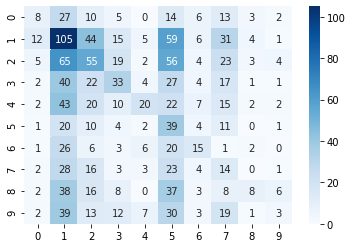

In [18]:
analyze_and_predict()

In [32]:
# for i in d:
#     for n in range(len(d[i])):
#         if isinstance(d[i][n], int):
#             d[i][n] = str(d[i][n])
# #             print('changed')
# #             print(type(d[i][n]))

In [33]:
# with open('../data/ocr1/answers2.json', 'w') as f:
#     json.dump(d, f)